In [8]:
import cv2
import numpy as np
import pywt
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

from skimage.metrics import structural_similarity as ssim

# optional dtcwt
try:
    import dtcwt
    DTCWT_AVAILABLE = True
except Exception:
    DTCWT_AVAILABLE = False
    warnings.warn("dtcwt not available. DCHWT will fall back to DWT fusion.")

# ---------- Basic metrics ----------
def psnr(img_ref, img_test):
    img_ref = img_ref.astype(np.float64)
    img_test = img_test.astype(np.float64)
    mse = np.mean((img_ref - img_test) ** 2)
    if mse == 0:
        return float('inf')
    return 20.0 * np.log10(255.0 / np.sqrt(mse))

def rmse(img_ref, img_test):
    return np.sqrt(np.mean((img_ref.astype(np.float64) - img_test.astype(np.float64)) ** 2))

def mae(img_ref, img_test):
    return np.mean(np.abs(img_ref.astype(np.float64) - img_test.astype(np.float64)))

def entropy(image):
    arr = image.flatten().astype(np.uint8)
    hist, _ = np.histogram(arr, bins=256, range=(0,256))
    prob = hist / (hist.sum() + 1e-12)
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))

def mutual_information(a, b, bins=256):
    a = a.flatten()
    b = b.flatten()
    hgram, x_edges, y_edges = np.histogram2d(a, b, bins=bins)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    nzs = pxy > 0
    # Corrected calculation of mi
    # Get the indices of the non-zero elements
    nz_indices = np.nonzero(nzs)
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / (px[nz_indices[0]] * py[nz_indices[1]])))
    return mi

# ---------- small helpers ----------
def local_energy(img, win=5):
    # local sum of squared values (activity)
    sq = img.astype(np.float32) ** 2
    kernel = np.ones((win, win), dtype=np.float32)
    return cv2.filter2D(sq, -1, kernel, borderType=cv2.BORDER_REFLECT)

def small_unsharp(image, radius=0.5, amount=0.6):
    img = image.astype(np.float32)
    blurred = ndimage.gaussian_filter(img, sigma=radius)
    mask = img - blurred
    result = img + amount * mask
    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)

def bilateral_sharpen(image, d=5, sigma_color=75, sigma_space=75, unsharp_amt=0.6):
    # reduce noise while keeping edges, then light unsharp
    den = cv2.bilateralFilter(image, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    return small_unsharp(den, radius=0.7, amount=unsharp_amt)

# ---------- DCT fusion: coefficient-wise with DC-weighted average ----------
def dct_improved_fusion(img1, img2, block_size=8):
    assert img1.shape == img2.shape
    h, w = img1.shape
    img1f = img1.astype(np.float32)
    img2f = img2.astype(np.float32)
    fused = np.zeros_like(img1f)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            bi = slice(i, min(i+block_size, h))
            bj = slice(j, min(j+block_size, w))
            b1 = img1f[bi, bj]
            b2 = img2f[bi, bj]
            bh = b1.shape[0]; bw = b1.shape[1]

            pad1 = np.zeros((block_size, block_size), dtype=np.float32)
            pad2 = np.zeros((block_size, block_size), dtype=np.float32)
            pad1[:bh, :bw] = b1
            pad2[:bh, :bw] = b2

            D1 = cv2.dct(pad1)
            D2 = cv2.dct(pad2)

            # compute local activity (energy) per block to weight low-freq
            e1 = np.sum(np.abs(D1)) - abs(D1[0,0])
            e2 = np.sum(np.abs(D2)) - abs(D2[0,0])
            # DC weight favors block with stronger energy but keep mix
            alpha = e1 / (e1 + e2 + 1e-12)
            # average DC and some low-frequency neighborhood
            low_mix = D1.copy()
            low_mix[0:2, 0:2] = alpha * D1[0:2, 0:2] + (1 - alpha) * D2[0:2, 0:2]

            # For other coefficients select by max-abs
            sel = np.where(np.abs(D1) >= np.abs(D2), D1, D2)
            sel[0:2, 0:2] = low_mix[0:2, 0:2]

            idct = cv2.idct(sel)
            fused[bi, bj] = idct[:bh, :bw]

    fused = np.clip(fused, 0, 255).astype(np.uint8)
    # gentle postprocess
    fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.6)
    return fused

# ---------- DWT improved fusion: 2-level, local-energy-weighted lowpass and max-abs details ----------
def dwt_improved_fusion(img1, img2, wavelet='db2', level=2):
    coeffs1 = pywt.wavedec2(img1.astype(np.float32), wavelet=wavelet, level=level)
    coeffs2 = pywt.wavedec2(img2.astype(np.float32), wavelet=wavelet, level=level)

    # weighted lowpass: compute local energies on approximation images
    A1 = coeffs1[0]; A2 = coeffs2[0]
    # local energy windowsize depends on image size
    win = 7
    e1 = local_energy(A1, win=win)
    e2 = local_energy(A2, win=win)
    w = e1 / (e1 + e2 + 1e-12)
    fused_A = w * A1 + (1 - w) * A2

    fused_coeffs = [fused_A]
    # fuse details per-level: max-abs with minor weighting by local activity
    for d1, d2 in zip(coeffs1[1:], coeffs2[1:]):
        fused_d = []
        for sub1, sub2 in zip(d1, d2):
            la = local_energy(np.abs(sub1), win=5)
            lb = local_energy(np.abs(sub2), win=5)
            mask = np.abs(sub1) >= np.abs(sub2)
            # also mix small areas where energies close
            close_mask = (np.abs(np.abs(sub1) - np.abs(sub2)) < 1e-2)
            fused = np.where(mask, sub1, sub2)
            fused = np.where(close_mask, 0.5 * (sub1 + sub2), fused)
            fused_d.append(fused)
        fused_coeffs.append(tuple(fused_d))

    fused = pywt.waverec2(fused_coeffs, wavelet=wavelet)
    fused = np.clip(fused, 0, 255).astype(np.uint8)
    fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
    return fused

# ---------- SWT improved fusion (2-level) ----------
def swt_improved_fusion(img1, img2, wavelet='db2', level=2):
    coeffs1 = pywt.swt2(img1.astype(np.float32), wavelet=wavelet, level=level)
    coeffs2 = pywt.swt2(img2.astype(np.float32), wavelet=wavelet, level=level)
    fused_coeffs = []
    for (A1, D1), (A2, D2) in zip(coeffs1, coeffs2):
        e1 = local_energy(A1, win=7)
        e2 = local_energy(A2, win=7)
        w = e1 / (e1 + e2 + 1e-12)
        fusedA = w * A1 + (1 - w) * A2
        fusedD = tuple(np.where(np.abs(d1) >= np.abs(d2), d1, d2) for d1, d2 in zip(D1, D2))
        fused_coeffs.append((fusedA, fusedD))
    fused = pywt.iswt2(fused_coeffs, wavelet=wavelet)
    fused = np.clip(fused, 0, 255).astype(np.uint8)
    fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
    return fused

# ---------- DCHWT improved fusion ----------
def dchwt_improved_fusion(img1, img2):
    if not DTCWT_AVAILABLE:
        warnings.warn("dtcwt not available. Falling back to DWT improved fusion.")
        return dwt_improved_fusion(img1, img2, wavelet='db2', level=2)
    transform = dtcwt.Transform2d()
    t1 = transform.forward(img1.astype(np.float32), nlevels=3)
    t2 = transform.forward(img2.astype(np.float32), nlevels=3)
    fused_low = (t1.lowpass + t2.lowpass) / 2.0
    fused_high = []
    for hp1, hp2 in zip(t1.highpasses, t2.highpasses):
        mag1 = np.abs(hp1)
        mag2 = np.abs(hp2)
        mask = mag1 >= mag2
        fused = np.where(mask, hp1, hp2)
        fused_high.append(fused)
    fused_image = transform.inverse(fused_low, fused_high)
    fused_image = np.clip(fused_image, 0, 255).astype(np.uint8)
    fused_image = bilateral_sharpen(fused_image, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
    return fused_image

# ---------- Wrapper map ----------
def dwt_um(img1, img2): return bilateral_sharpen(dwt_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
def dwt_hb(img1, img2): return bilateral_sharpen(dwt_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.8)
def dct_um(img1, img2): return bilateral_sharpen(dct_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.6)
def dct_hb(img1, img2): return bilateral_sharpen(dct_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.9)

# ---------- Main ----------
if __name__ == "__main__":
    # paths - update if needed
    img1 = cv2.imread('/content/source09_1.tif', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread('/content/source09_1.tif_10.jpg', cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        raise FileNotFoundError("Place source images in working folder or update paths.")

    if img1.shape != img2.shape:
        min_h = min(img1.shape[0], img2.shape[0])
        min_w = min(img1.shape[1], img2.shape[1])
        img1 = img1[:min_h, :min_w]
        img2 = img2[:min_h, :min_w]

    methods = {
        'SWT'   : lambda a,b: swt_improved_fusion(a,b, wavelet='db2', level=2),
        'DCHWT' : dchwt_improved_fusion,
        'DWT'   : lambda a,b: dwt_improved_fusion(a,b, wavelet='db2', level=2),
        'DWT+UM': lambda a,b: dwt_um(a,b),
        'DWT+HB': lambda a,b: dwt_hb(a,b),
        'DCT'   : lambda a,b: dct_improved_fusion(a,b, block_size=8),
        'DCT+UM': lambda a,b: dct_um(a,b),
        'DCT+HB': lambda a,b: dct_hb(a,b)
    }

    # reference_mode: 'img1' (default single reference), 'img2', 'mean' (mean of sources)
    reference_mode = 'img1'
    reference = img1 if reference_mode == 'img1' else (img2 if reference_mode == 'img2' else ((img1.astype(np.float32)+img2.astype(np.float32))/2).astype(np.uint8))

    results = {}
    for name, func in methods.items():
        try:
            fused = func(img1, img2)
        except Exception as e:
            print(f"Error in {name}: {e}")
            continue

        if fused.dtype != np.uint8:
            fused = np.clip(fused, 0, 255).astype(np.uint8)

        fname = f"fused_{name.replace('+','plus')}.png"
        cv2.imwrite(fname, fused)

        # metrics
        psnr_val = psnr(reference, fused)
        rmse_val = rmse(reference, fused)
        mae_val = mae(reference, fused)
        ent = entropy(fused)
        ssim_val = ssim(reference, fused, data_range=255)
        mi_with_img1 = mutual_information(fused, img1, bins=128)
        mi_with_img2 = mutual_information(fused, img2, bins=128)
        psnr_mean = 0.5 * (psnr(img1, fused) + psnr(img2, fused))

        results[name] = {
            'file': fname,
            'psnr' : psnr_val,
            'rmse' : rmse_val,
            'mae'  : mae_val,
            'entropy': ent,
            'ssim': ssim_val,
            'mi_img1': mi_with_img1,
            'mi_img2': mi_with_img2,
            'psnr_mean': psnr_mean
        }

    # print concise results
    print("\nImproved Fusion results (reference_mode = {})\n".format(reference_mode))
    for name, st in results.items():
        print(f"Method: {name}")
        print(f"  File      : {st['file']}")
        print(f"  PSNR      : {st['psnr']:.4f}")
        print(f"  RMSE      : {st['rmse']:.4f}")
        print(f"  MAE       : {st['mae']:.4f}")
        print(f"  Entropy   : {st['entropy']:.6f}")
        print(f"  SSIM      : {st['ssim']:.4f}")
        print(f"  MI img1   : {st['mi_img1']:.4f}")
        print(f"  MI img2   : {st['mi_img2']:.4f}")
        print(f"  PSNR mean : {st['psnr_mean']:.4f}")
        print("")

    print("Done. Fused images saved.")


Improved Fusion results (reference_mode = img1)

Method: SWT
  File      : fused_SWT.png
  PSNR      : 30.4923
  RMSE      : 7.6195
  MAE       : 5.2892
  Entropy   : 7.174086
  SSIM      : 0.9334
  MI img1   : 1.8621
  MI img2   : 1.8594
  PSNR mean : 30.4979

Method: DCHWT
  File      : fused_DCHWT.png
  PSNR      : 30.3162
  RMSE      : 7.7755
  MAE       : 5.3825
  Entropy   : 7.176169
  SSIM      : 0.9304
  MI img1   : 1.8436
  MI img2   : 1.8385
  PSNR mean : 30.2984

Method: DWT
  File      : fused_DWT.png
  PSNR      : 30.3162
  RMSE      : 7.7755
  MAE       : 5.3825
  Entropy   : 7.176169
  SSIM      : 0.9304
  MI img1   : 1.8436
  MI img2   : 1.8385
  PSNR mean : 30.2984

Method: DWT+UM
  File      : fused_DWTplusUM.png
  PSNR      : 27.2603
  RMSE      : 11.0542
  MAE       : 7.6044
  Entropy   : 7.125141
  SSIM      : 0.8718
  MI img1   : 1.6243
  MI img2   : 1.6272
  PSNR mean : 27.3538

Method: DWT+HB
  File      : fused_DWTplusHB.png
  PSNR      : 27.5474
  RMSE      :

/tmp/ipython-input-9636617.py:16: UserWarning: dtcwt not available. DCHWT will fall back to DWT fusion.
  warnings.warn("dtcwt not available. DCHWT will fall back to DWT fusion.")
/tmp/ipython-input-9636617.py:158: UserWarning: dtcwt not available. Falling back to DWT improved fusion.
  warnings.warn("dtcwt not available. Falling back to DWT improved fusion.")


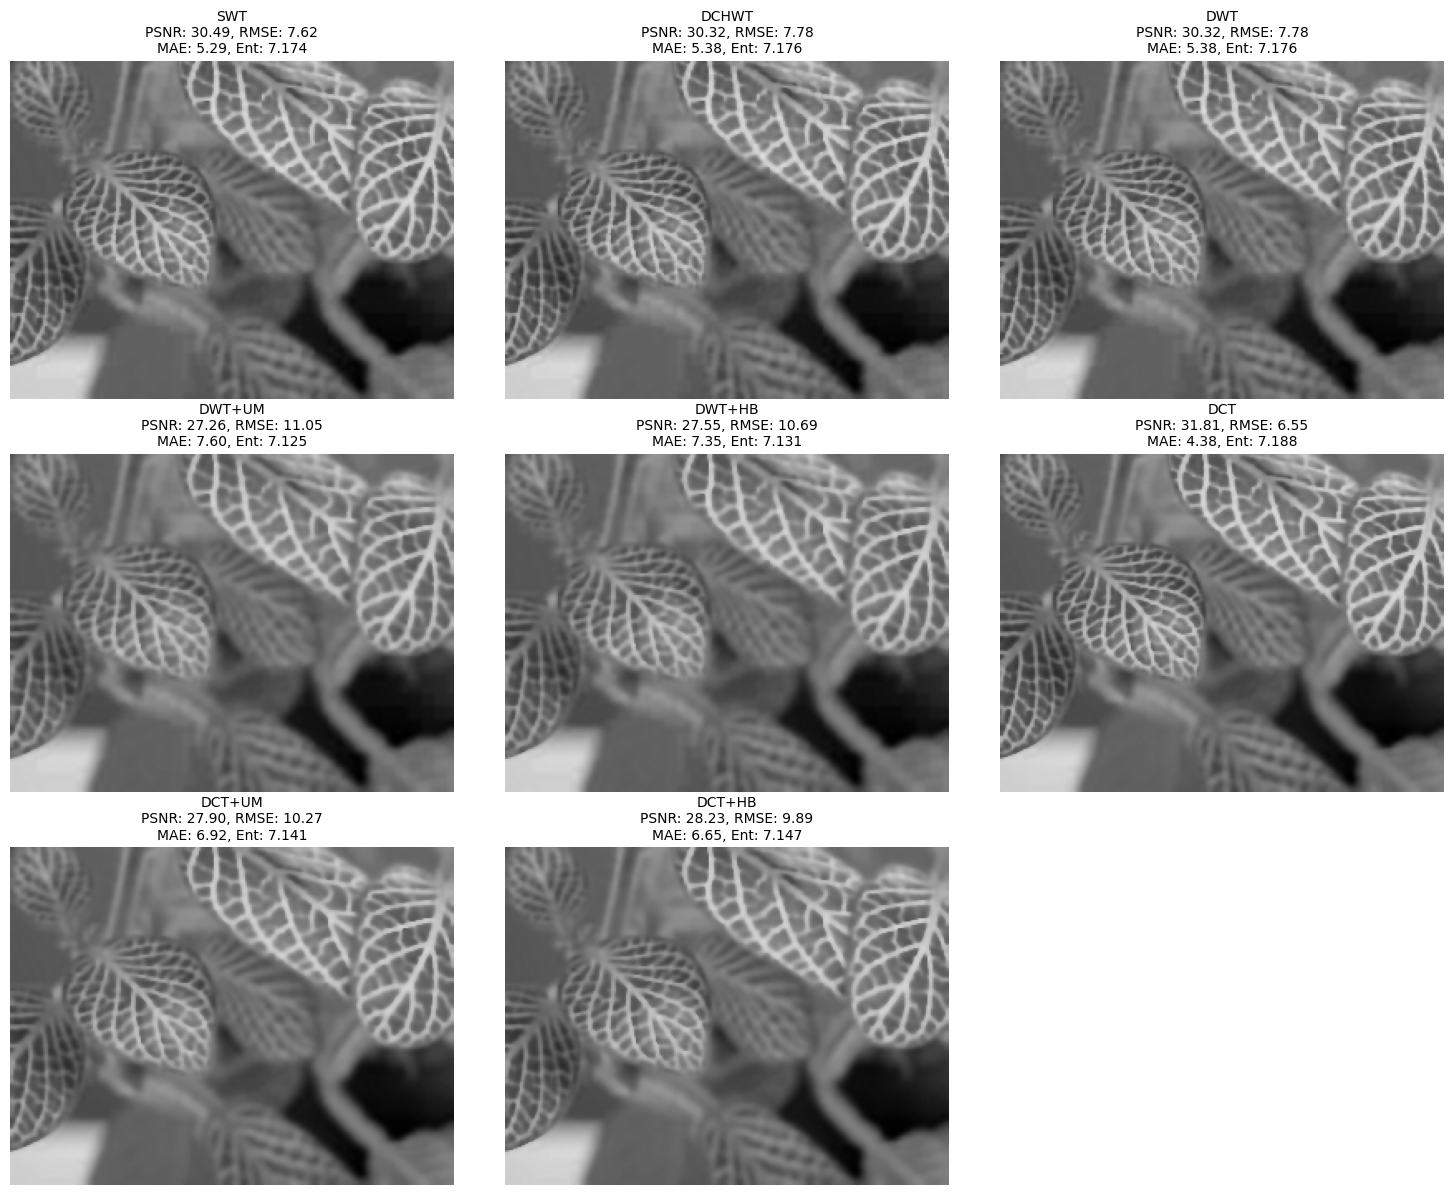


Improved Fusion results (reference_mode = img1)

Method: SWT
  File      : fused_SWT.png
  PSNR      : 30.4923
  RMSE      : 7.6195
  MAE       : 5.2892
  Entropy   : 7.174086
  SSIM      : 0.9334
  MI img1   : 1.8621
  MI img2   : 1.8594
  PSNR mean : 30.4979

Method: DCHWT
  File      : fused_DCHWT.png
  PSNR      : 30.3162
  RMSE      : 7.7755
  MAE       : 5.3825
  Entropy   : 7.176169
  SSIM      : 0.9304
  MI img1   : 1.8436
  MI img2   : 1.8385
  PSNR mean : 30.2984

Method: DWT
  File      : fused_DWT.png
  PSNR      : 30.3162
  RMSE      : 7.7755
  MAE       : 5.3825
  Entropy   : 7.176169
  SSIM      : 0.9304
  MI img1   : 1.8436
  MI img2   : 1.8385
  PSNR mean : 30.2984

Method: DWT+UM
  File      : fused_DWTplusUM.png
  PSNR      : 27.2603
  RMSE      : 11.0542
  MAE       : 7.6044
  Entropy   : 7.125141
  SSIM      : 0.8718
  MI img1   : 1.6243
  MI img2   : 1.6272
  PSNR mean : 27.3538

Method: DWT+HB
  File      : fused_DWTplusHB.png
  PSNR      : 27.5474
  RMSE      :

In [7]:
# import cv2
# import numpy as np
# import pywt
# from scipy import ndimage
# import warnings
# from skimage.metrics import structural_similarity as ssim
# import matplotlib.pyplot as plt
# import math

# # optional dtcwt
# try:
#     import dtcwt
#     DTCWT_AVAILABLE = True
# except Exception:
#     DTCWT_AVAILABLE = False
#     warnings.warn("dtcwt not available. DCHWT will fall back to DWT fusion.")

# # ---------- Basic metrics ----------
# def psnr(img_ref, img_test):
#     img_ref = img_ref.astype(np.float64)
#     img_test = img_test.astype(np.float64)
#     mse = np.mean((img_ref - img_test) ** 2)
#     if mse == 0:
#         return float('inf')
#     return 20.0 * np.log10(255.0 / np.sqrt(mse))

# def rmse(img_ref, img_test):
#     return np.sqrt(np.mean((img_ref.astype(np.float64) - img_test.astype(np.float64)) ** 2))

# def mae(img_ref, img_test):
#     return np.mean(np.abs(img_ref.astype(np.float64) - img_test.astype(np.float64)))

# def entropy(image):
#     arr = image.flatten().astype(np.uint8)
#     hist, _ = np.histogram(arr, bins=256, range=(0,256))
#     prob = hist / (hist.sum() + 1e-12)
#     prob = prob[prob > 0]
#     return -np.sum(prob * np.log2(prob))

# def mutual_information(a, b, bins=256):
#     a = a.flatten()
#     b = b.flatten()
#     hgram, x_edges, y_edges = np.histogram2d(a, b, bins=bins)
#     pxy = hgram / float(np.sum(hgram))
#     px = np.sum(pxy, axis=1)
#     py = np.sum(pxy, axis=0)
#     nzs = pxy > 0
#     nz_indices = np.nonzero(nzs)
#     mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / (px[nz_indices[0]] * py[nz_indices[1]])))
#     return mi

# # ---------- small helpers ----------
# def local_energy(img, win=5):
#     sq = img.astype(np.float32) ** 2
#     kernel = np.ones((win, win), dtype=np.float32)
#     return cv2.filter2D(sq, -1, kernel, borderType=cv2.BORDER_REFLECT)

# def small_unsharp(image, radius=0.5, amount=0.6):
#     img = image.astype(np.float32)
#     blurred = ndimage.gaussian_filter(img, sigma=radius)
#     mask = img - blurred
#     result = img + amount * mask
#     result = np.clip(result, 0, 255)
#     return result.astype(np.uint8)

# def bilateral_sharpen(image, d=5, sigma_color=75, sigma_space=75, unsharp_amt=0.6):
#     den = cv2.bilateralFilter(image, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
#     return small_unsharp(den, radius=0.7, amount=unsharp_amt)

# # ---------- DCT fusion ----------
# def dct_improved_fusion(img1, img2, block_size=8):
#     assert img1.shape == img2.shape
#     h, w = img1.shape
#     img1f = img1.astype(np.float32)
#     img2f = img2.astype(np.float32)
#     fused = np.zeros_like(img1f)

#     for i in range(0, h, block_size):
#         for j in range(0, w, block_size):
#             bi = slice(i, min(i+block_size, h))
#             bj = slice(j, min(j+block_size, w))
#             b1 = img1f[bi, bj]
#             b2 = img2f[bi, bj]
#             bh = b1.shape[0]; bw = b1.shape[1]

#             pad1 = np.zeros((block_size, block_size), dtype=np.float32)
#             pad2 = np.zeros((block_size, block_size), dtype=np.float32)
#             pad1[:bh, :bw] = b1
#             pad2[:bh, :bw] = b2

#             D1 = cv2.dct(pad1)
#             D2 = cv2.dct(pad2)

#             e1 = np.sum(np.abs(D1)) - abs(D1[0,0])
#             e2 = np.sum(np.abs(D2)) - abs(D2[0,0])
#             alpha = e1 / (e1 + e2 + 1e-12)
#             low_mix = D1.copy()
#             low_mix[0:2, 0:2] = alpha * D1[0:2, 0:2] + (1 - alpha) * D2[0:2, 0:2]

#             sel = np.where(np.abs(D1) >= np.abs(D2), D1, D2)
#             sel[0:2, 0:2] = low_mix[0:2, 0:2]

#             idct = cv2.idct(sel)
#             fused[bi, bj] = idct[:bh, :bw]

#     fused = np.clip(fused, 0, 255).astype(np.uint8)
#     fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.6)
#     return fused

# # ---------- DWT fusion ----------
# def dwt_improved_fusion(img1, img2, wavelet='db2', level=2):
#     coeffs1 = pywt.wavedec2(img1.astype(np.float32), wavelet=wavelet, level=level)
#     coeffs2 = pywt.wavedec2(img2.astype(np.float32), wavelet=wavelet, level=level)

#     A1 = coeffs1[0]; A2 = coeffs2[0]
#     win = 7
#     e1 = local_energy(A1, win=win)
#     e2 = local_energy(A2, win=win)
#     w = e1 / (e1 + e2 + 1e-12)
#     fused_A = w * A1 + (1 - w) * A2

#     fused_coeffs = [fused_A]
#     for d1, d2 in zip(coeffs1[1:], coeffs2[1:]):
#         fused_d = []
#         for sub1, sub2 in zip(d1, d2):
#             mask = np.abs(sub1) >= np.abs(sub2)
#             close_mask = (np.abs(np.abs(sub1) - np.abs(sub2)) < 1e-2)
#             fused = np.where(mask, sub1, sub2)
#             fused = np.where(close_mask, 0.5 * (sub1 + sub2), fused)
#             fused_d.append(fused)
#         fused_coeffs.append(tuple(fused_d))

#     fused = pywt.waverec2(fused_coeffs, wavelet=wavelet)
#     fused = np.clip(fused, 0, 255).astype(np.uint8)
#     fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
#     return fused

# # ---------- SWT fusion ----------
# def swt_improved_fusion(img1, img2, wavelet='db2', level=2):
#     coeffs1 = pywt.swt2(img1.astype(np.float32), wavelet=wavelet, level=level)
#     coeffs2 = pywt.swt2(img2.astype(np.float32), wavelet=wavelet, level=level)
#     fused_coeffs = []
#     for (A1, D1), (A2, D2) in zip(coeffs1, coeffs2):
#         e1 = local_energy(A1, win=7)
#         e2 = local_energy(A2, win=7)
#         w = e1 / (e1 + e2 + 1e-12)
#         fusedA = w * A1 + (1 - w) * A2
#         fusedD = tuple(np.where(np.abs(d1) >= np.abs(d2), d1, d2) for d1, d2 in zip(D1, D2))
#         fused_coeffs.append((fusedA, fusedD))
#     fused = pywt.iswt2(fused_coeffs, wavelet=wavelet)
#     fused = np.clip(fused, 0, 255).astype(np.uint8)
#     fused = bilateral_sharpen(fused, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
#     return fused

# # ---------- DCHWT ----------
# def dchwt_improved_fusion(img1, img2):
#     if not DTCWT_AVAILABLE:
#         warnings.warn("dtcwt not available. Falling back to DWT improved fusion.")
#         return dwt_improved_fusion(img1, img2, wavelet='db2', level=2)
#     transform = dtcwt.Transform2d()
#     t1 = transform.forward(img1.astype(np.float32), nlevels=3)
#     t2 = transform.forward(img2.astype(np.float32), nlevels=3)
#     fused_low = (t1.lowpass + t2.lowpass) / 2.0
#     fused_high = []
#     for hp1, hp2 in zip(t1.highpasses, t2.highpasses):
#         mag1 = np.abs(hp1)
#         mag2 = np.abs(hp2)
#         mask = mag1 >= mag2
#         fused = np.where(mask, hp1, hp2)
#         fused_high.append(fused)
#     fused_image = transform.inverse(fused_low, fused_high)
#     fused_image = np.clip(fused_image, 0, 255).astype(np.uint8)
#     fused_image = bilateral_sharpen(fused_image, d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
#     return fused_image

# # ---------- Wrappers ----------
# def dwt_um(img1, img2): return bilateral_sharpen(dwt_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.5)
# def dwt_hb(img1, img2): return bilateral_sharpen(dwt_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.8)
# def dct_um(img1, img2): return bilateral_sharpen(dct_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.6)
# def dct_hb(img1, img2): return bilateral_sharpen(dct_improved_fusion(img1, img2), d=5, sigma_color=60, sigma_space=60, unsharp_amt=0.9)

# # ---------- Main ----------
# if __name__ == "__main__":
#     # update these paths if needed
#     img1 = cv2.imread('/content/source09_1.tif', cv2.IMREAD_GRAYSCALE)
#     img2 = cv2.imread('/content/source09_1.tif_10.jpg', cv2.IMREAD_GRAYSCALE)
#     if img1 is None or img2 is None:
#         raise FileNotFoundError("Place source images in working folder or update paths.")

#     if img1.shape != img2.shape:
#         min_h = min(img1.shape[0], img2.shape[0])
#         min_w = min(img1.shape[1], img2.shape[1])
#         img1 = img1[:min_h, :min_w]
#         img2 = img2[:min_h, :min_w]

#     methods = {
#         'SWT'   : lambda a,b: swt_improved_fusion(a,b, wavelet='db2', level=2),
#         'DCHWT' : dchwt_improved_fusion,
#         'DWT'   : lambda a,b: dwt_improved_fusion(a,b, wavelet='db2', level=2),
#         'DWT+UM': lambda a,b: dwt_um(a,b),
#         'DWT+HB': lambda a,b: dwt_hb(a,b),
#         'DCT'   : lambda a,b: dct_improved_fusion(a,b, block_size=8),
#         'DCT+UM': lambda a,b: dct_um(a,b),
#         'DCT+HB': lambda a,b: dct_hb(a,b)
#     }

#     reference_mode = 'img1'
#     reference = img1 if reference_mode == 'img1' else (img2 if reference_mode == 'img2' else ((img1.astype(np.float32)+img2.astype(np.float32))/2).astype(np.uint8))

#     results = {}
#     fused_images = []  # keep in memory for plotting

#     for name, func in methods.items():
#         try:
#             fused = func(img1, img2)
#         except Exception as e:
#             print(f"Error in {name}: {e}")
#             continue

#         if fused.dtype != np.uint8:
#             fused = np.clip(fused, 0, 255).astype(np.uint8)

#         fname = f"fused_{name.replace('+','plus')}.png"
#         cv2.imwrite(fname, fused)

#         # metrics
#         psnr_val = psnr(reference, fused)
#         rmse_val = rmse(reference, fused)
#         mae_val = mae(reference, fused)
#         ent = entropy(fused)
#         ssim_val = ssim(reference, fused, data_range=255)
#         mi_with_img1 = mutual_information(fused, img1, bins=128)
#         mi_with_img2 = mutual_information(fused, img2, bins=128)
#         psnr_mean = 0.5 * (psnr(img1, fused) + psnr(img2, fused))

#         results[name] = {
#             'file': fname,
#             'psnr' : psnr_val,
#             'rmse' : rmse_val,
#             'mae'  : mae_val,
#             'entropy': ent,
#             'ssim': ssim_val,
#             'mi_img1': mi_with_img1,
#             'mi_img2': mi_with_img2,
#             'psnr_mean': psnr_mean
#         }

#         fused_images.append((name, fused, results[name]))

#     # ----- Plot fused images in a grid with metrics in the title -----
#     n = len(fused_images)
#     if n > 0:
#         cols = 3
#         rows = math.ceil(n / cols)
#         plt.figure(figsize=(5 * cols, 4 * rows))
#         for idx, (name, img, stats) in enumerate(fused_images, start=1):
#             ax = plt.subplot(rows, cols, idx)
#             ax.imshow(img, cmap='gray', vmin=0, vmax=255)
#             title = (f"{name}\nPSNR: {stats['psnr']:.2f}, RMSE: {stats['rmse']:.2f}\n"
#                      f"MAE: {stats['mae']:.2f}, Ent: {stats['entropy']:.3f}")
#             ax.set_title(title, fontsize=10)
#             ax.axis('off')
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("No fused images to display.")

#     # print concise results in console
#     print("\nImproved Fusion results (reference_mode = {})\n".format(reference_mode))
#     for name, st in results.items():
#         print(f"Method: {name}")
#         print(f"  File      : {st['file']}")
#         print(f"  PSNR      : {st['psnr']:.4f}")
#         print(f"  RMSE      : {st['rmse']:.4f}")
#         print(f"  MAE       : {st['mae']:.4f}")
#         print(f"  Entropy   : {st['entropy']:.6f}")
#         print(f"  SSIM      : {st['ssim']:.4f}")
#         print(f"  MI img1   : {st['mi_img1']:.4f}")
#         print(f"  MI img2   : {st['mi_img2']:.4f}")
#         print(f"  PSNR mean : {st['psnr_mean']:.4f}")
#         print("")

#     print("Done. Fused images saved and displayed.")
